In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
from sklearn.datasets import fetch_mldata, fetch_lfw_people
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from collections import defaultdict
from sklearn.ensemble import VotingClassifier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## 2. Ensemble Learning
### (a) Load two text-based classiffication datasets (e.g., from NLTK or Kaggle) and pre- process as necessary to arrive at a numerical representation of the text. (Code)

### (a) [What's Cooking?](https://www.kaggle.com/c/whats-cooking)
classify cuisine based on ingredients

In [21]:
cook_train = pd.read_json('cooking_train.json',orient='records').set_index('id')
cook_test = pd.read_json('cooking_test.json',orient='records').set_index('id')

In [22]:
cook_train.sample(5)

,cuisine,ingredients
id,,
23243,italian,"[sweet onion, salt, small red potato, dough, o..."
29455,japanese,"[green cardamom, milk, cinnamon sticks, conden..."
16876,greek,"[ground black pepper, purple onion, cucumber, ..."
47661,southern_us,"[flour, buttermilk, butter, baking powder, sal..."
38521,italian,"[black pepper, vegetable broth, boiling water,..."


In [23]:
cook_train['cuisine'].nunique()

20

In [24]:
cook_test.head(2)

,ingredients
id,
18009,"[baking powder, eggs, all-purpose flour, raisi..."
28583,"[sugar, egg yolks, corn starch, cream of tarta..."


In [89]:
# there's no label for the test set provided, 
# so I've split cooking_train into training and testing sets (75/25)
cooking = cook_train
cooking.shape

(39774, 2)

In [90]:
cooking.dropna(axis=0, how='any', inplace=True)

In [91]:
# split "ingredient" into multiple columns
# and fill in missing values with 0
cooking = pd.concat([pd.DataFrame(cooking['ingredients'].values.tolist()), (cooking['cuisine'])], axis=1)
cooking.head(5)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,cuisine
0,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,None,...,None,None,None,None,None,None,None,None,None,spanish
1,plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,...,None,None,None,None,None,None,None,None,None,mexican
2,eggs,pepper,salt,mayonaise,cooking oil,green chilies,grilled chicken breasts,garlic powder,yellow onion,soy sauce,...,None,None,None,None,None,None,None,None,None,french
3,water,vegetable oil,wheat,salt,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,chinese
4,black pepper,shallots,cornflour,cayenne pepper,onions,garlic paste,milk,butter,salt,lemon juice,...,None,None,None,None,None,None,None,None,None,italian


In [92]:
cooking.iloc[:,:65] = cooking.iloc[:,:65].fillna(value=0.0)
cooking.head(5)

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,cuisine
0,romaine lettuce,black olives,grape tomatoes,garlic,pepper,purple onion,seasoning,garbanzo beans,feta cheese crumbles,0,...,0,0,0,0,0,0,0,0,0,spanish
1,plain flour,ground pepper,salt,tomatoes,ground black pepper,thyme,eggs,green tomatoes,yellow corn meal,milk,...,0,0,0,0,0,0,0,0,0,mexican
2,eggs,pepper,salt,mayonaise,cooking oil,green chilies,grilled chicken breasts,garlic powder,yellow onion,soy sauce,...,0,0,0,0,0,0,0,0,0,french
3,water,vegetable oil,wheat,salt,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,chinese
4,black pepper,shallots,cornflour,cayenne pepper,onions,garlic paste,milk,butter,salt,lemon juice,...,0,0,0,0,0,0,0,0,0,italian


In [95]:
cooking.dropna(subset=['cuisine'], how='any', inplace=True)

In [138]:
#  sample 1000 from the dataset due to memory consumption
cooking = cooking.sample(1000)   
cooking_X = cooking.iloc[:,:65]
cooking_Y = cooking['cuisine']

# sklearn.OneHotEncoder doesn't take string-based values
cooking_X = pd.get_dummies(cooking_X)

In [143]:
cooking_X.shape

(1000, 5003)

In [144]:
cooking_X_train, cooking_X_test, cooking_Y_train, cooking_Y_test = train_test_split(cooking_X, cooking_Y)
print("train shape: {}\ntest shape: {}".format(cooking_X_train.shape, cooking_X_test.shape))

train shape: (750, 5003)
test shape: (250, 5003)


In [145]:
sc = StandardScaler()
cooking_X_train_scaled = sc.fit_transform(cooking_X_train)
cooking_X_test_scaled = sc.transform(cooking_X_test)

le = LabelEncoder()
cooking_Y_train_enc = le.fit_transform(cooking_Y_train)
cooking_Y_test_enc = le.transform(cooking_Y_test)

In [147]:
%store cooking_X_train_scaled
%store cooking_X_test_scaled
%store cooking_Y_train_enc
%store cooking_Y_test_enc

Stored 'cooking_X_train_scaled' (ndarray)
Stored 'cooking_X_test_scaled' (ndarray)
Stored 'cooking_Y_train_enc' (ndarray)
Stored 'cooking_Y_test_enc' (ndarray)


### (a) [Mushroom Classification](https://www.kaggle.com/uciml/mushroom-classification/home)
Predict edible vs poisonous mushrooms

In [2]:
mushrooms = pd.read_csv('mushrooms.csv')

In [3]:
mushrooms.shape

(8124, 23)

In [4]:
mushrooms['class'].nunique()

2

In [5]:
mushrooms.isnull().any()

class                       False
cap-shape                   False
cap-surface                 False
cap-color                   False
bruises                     False
odor                        False
gill-attachment             False
gill-spacing                False
gill-size                   False
gill-color                  False
stalk-shape                 False
stalk-root                  False
stalk-surface-above-ring    False
stalk-surface-below-ring    False
stalk-color-above-ring      False
stalk-color-below-ring      False
veil-type                   False
veil-color                  False
ring-number                 False
ring-type                   False
spore-print-color           False
population                  False
habitat                     False
dtype: bool

In [6]:
mushrooms.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [7]:
mushroom_X, mushroom_Y = mushrooms.iloc[:,1:], mushrooms['class']

In [66]:
X_train, X_test, Y_train, Y_test = train_test_split(pd.get_dummies(mushroom_X), mushroom_Y)

In [12]:
mushroom_d = defaultdict(LabelEncoder)
mushroom_X_fit = mushroom_X.apply(lambda x: mushroom_d[x.name].fit_transform(x))

In [13]:
le_Y = LabelEncoder()
mushroom_Y_fit = le_Y.fit_transform(mushroom_Y)

In [32]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# sklearn.LabelEncoder handles a single vector one at a time
# so one hot encodig X has to be completed column-by-clumn
# for 22 columns. The result is a sparse matrix with 95 features

def multicolumn_onehot_mushroom(X):
    
    onehot = defaultdict(OneHotEncoder)
    df = pd.DataFrame()

    for i in range(22):
        
        curr = pd.DataFrame(onehot[X.columns[i]].fit_transform(X.iloc[:, i:i+1]).toarray())
    
        oh = onehot[X.columns[i]]
        labelEncoder_i = mushroom_d[X.columns[i]]
        curr.columns = X.columns[i] + " " + labelEncoder_i.inverse_transform(oh.active_features_)
    
        X_onehot_i = curr.iloc[:,1:]

        df = pd.concat([df, X_onehot_i], axis=1)
    
    return df

In [33]:
mushroom_X_df = multicolumn_onehot_mushroom(mushroom_X_fit)

In [34]:
mushroom_X_df.head(10)

,cap-shape c,cap-shape f,cap-shape k,cap-shape s,cap-shape x,cap-surface g,cap-surface s,cap-surface y,cap-color c,cap-color e,...,population n,population s,population v,population y,habitat g,habitat l,habitat m,habitat p,habitat u,habitat w
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [37]:
mushroom_X_train, mushroom_X_test, mushroom_Y_train, mushroom_Y_test = train_test_split(mushroom_X_df.values, mushroom_Y_fit.reshape(-1,1))

sc = StandardScaler()
sc = sc.fit(mushroom_X_train)
mushroom_X_train_scaled = sc.transform(mushroom_X_train)
mushroom_X_test_scaled = sc.transform(mushroom_X_test)

## (b) For each dataset, evaluate these classiffiers using 10-fold cross validation: (Code)
### (i) Three different classifiers (e.g., SVM, Naive Bayes, Decision Tree, KNN).

In [98]:

kf = KFold(n_splits=10, shuffle=False, random_state=1)

def knn(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    k_list = [5, 10, 20, 30, 50, 80, 120]

    for k in k_list:
        cv_model = KNeighborsClassifier(n_neighbors=k)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
    cv_scores = np.asarray(cv_scores)
    print("10-fold cross-validated score on training set:", np.mean(cv_scores))
    
    best_k = k_list[cv_scores.argmax()]
    print("Best K =", best_k)
    model = KNeighborsClassifier(n_neighbors=best_k)
    model.fit(X_train, Y_train)

    print("Best score on test set:", model.score(X_test, Y_test))



    

def logit(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    C_list = [0.5, 1.0, 2.5, 5.0]
    
    for c in C_list:
        cv_model = LogisticRegression(C=c, random_state=2, warm_start=True)
        score = np.mean(cross_val_score(cv_model, X_train, Y_train, cv=kf))
        cv_scores.append(score)
        
    cv_scores = np.asarray(cv_scores)
    
    print("10-fold cross-validated score on training set:", np.mean(cv_scores))
    
    best_C = C_list[cv_scores.argmax()]
    print("Best C =", best_C)
    model = LogisticRegression(C=best_C, random_state=2, warm_start=True)
    model.fit(X_train, Y_train)
    
    print("Best score on test set:", model.score(X_test, Y_test))


    

def lda(X_train, X_test, Y_train, Y_test):
    
    cv_scores = np.mean(cross_val_score(LinearDiscriminantAnalysis(), X_train, Y_train, cv=kf))
    print("10-fold cross validation score on training set:", np.mean(cv_scores))
    
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, Y_train)
    
    print("Best score on test set:", model.score(X_test, Y_test))

#### cooking dataset

In [99]:
logit(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc)

10-fold cross-validated score on training set: 0.034999999999999996
Best C = 2.5
Best score on test set: 0.14


In [100]:
lda(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc)

10-fold cross validation score on training set: 0.10266666666666664
Best score on test set: 0.176


In [101]:
knn(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc)

10-fold cross-validated score on training set: 0.1337142857142857
Best K = 80
Best score on test set: 0.188


#### mushroom dataset

In [102]:
logit(mushroom_X_train, mushroom_X_test, mushroom_Y_train, mushroom_Y_test)

10-fold cross-validated score on training set: 0.9995894909688013
Best C = 2.5
Best score on test set: 1.0


In [104]:
knn(mushroom_X_train_scaled, mushroom_X_test_scaled, mushroom_Y_train, mushroom_Y_test)

10-fold cross-validated score on training set: 0.9945372880638972
Best K = 5
Best score on test set: 1.0


In [105]:
logit(mushroom_X_train_scaled, mushroom_X_test_scaled, mushroom_Y_train, mushroom_Y_test)

10-fold cross-validated score on training set: 1.0
Best C = 0.5
Best score on test set: 1.0


### ii. Majority vote classiffier that uses the three classiffiers from previous step

In [82]:
def majority_vote(X_train, X_test, Y_train, Y_test, k, C):
    
    lda = LinearDiscriminantAnalysis()
    knn = KNeighborsClassifier(n_neighbors=k)
    logit = LogisticRegression(C=C, random_state=2)
    
    clf = VotingClassifier(estimators=[('lda',lda),('knn',knn),('logit',logit)], voting='hard')
    
    cv_scores = cross_val_score(clf, X_train, Y_train, cv=10)
    
    print("10-fold cross validation score on training set:", np.mean(cv_scores))
    
    clf.fit(X_train, Y_train)
    print("Accuracy on test set:", clf.score(X_test, Y_test))

In [84]:
# majority voting, bagging and boosting below
# use the optimal tuning params from previous step on each dataset

majority_vote(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc, k=80, C=2.5)

10-fold cross validation score on training set: 0.1070529442483233
Accuracy on test set: 0.168


In [83]:
majority_vote(mushroom_X_train_scaled, mushroom_X_test_scaled, mushroom_Y_train, mushroom_Y_test, k=5, C=0.5)

10-fold cross validation score on training set: 0.99934291459287
Accuracy on test set: 1.0


### iii. Bagging

In [121]:
def bagging(X_train, X_test, Y_train, Y_test, k, C):
    
    knn = KNeighborsClassifier(n_neighbors=k)
    clf = BaggingClassifier(base_estimator=knn, oob_score=True, random_state=24)
    clf.fit(X_train, Y_train)
    print("OOB score, KNN:", clf.oob_score_)
    
    print("accuracy on test set:", clf.score(X_test, Y_test))

In [114]:
bagging(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc, k=80, C=2.5)

OOB score, KNN: 0.172
accuracy on test set: 0.204


In [115]:
bagging(mushroom_X_train_scaled, mushroom_X_test_scaled, mushroom_Y_train, mushroom_Y_test, k=5, C=0.5)

OOB score, KNN: 0.9955686853766618
accuracy on test set: 1.0


### iv. Boosting

In [139]:
def adaboost(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    learning_rates = [0.5, 1.0, 2.0]
    for n in learning_rates:
        clf = AdaBoostClassifier(n_estimators=30, learning_rate=n, random_state=9)
        cv_scores.append(np.mean(cross_val_score(clf, X_train, Y_train, cv=kf)))

    print("Best cross validated score:", max(cv_scores))
    
    best_rate = learning_rates[np.argmax(cv_scores)]
    AdaBoostClassifier(n_estimators=30, learning_rate=best_rate, random_state=9)
    
    clf.fit(X_train, Y_train)
    print("Accuracy on test set:", clf.score(X_test, Y_test))

In [140]:
def gb(X_train, X_test, Y_train, Y_test):
    
    cv_scores = []
    learning_rates = [0.1, 0.5, 1.0]
    
    for n in learning_rates:
        clf = GradientBoostingClassifier(learning_rate=n, subsample=.7, max_features='sqrt', random_state=9, warm_start=True)
        cv_scores.append(np.mean(cross_val_score(clf, X_train, Y_train, cv=kf)))
    
    print("Best cross validated score:", max(cv_scores))
    
    best_rate = learning_rates[np.argmax(cv_scores)]
    GradientBoostingClassifier(learning_rate=best_rate, subsample=.7, max_features='sqrt', random_state=9, warm_start=True)
    
    clf.fit(X_train, Y_train)
    print("Accuracy on test set:", clf.score(X_test, Y_test))

In [76]:
adaboost(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc)

Best cross validated score: 0.20023021258153656
Accuracy on test set: 0.016


In [132]:
gb(cooking_X_train_scaled, cooking_X_test_scaled, cooking_Y_train_enc, cooking_Y_test_enc)

Best cross validated score: 0.18133333333333332
Accuracy on test set: 0.012


In [154]:
adaboost(mushroom_X_train_scaled, mushroom_X_test_scaled, mushroom_Y_train, mushroom_Y_test)

Best cross validated score: 1.0
Accuracy on test set: 0.8887247661250616


In [133]:
gb(mushroom_X_train_scaled, mushroom_X_test_scaled, mushroom_Y_train, mushroom_Y_test)

Best cross validated score: 1.0
Accuracy on test set: 1.0


### (c) Report in a table the mean accuracy of each classier you evaluated in the previous step for each dataset. Consequently, your report should include two tables that each show six accuracy scores for the six methods. (Write-up)

Cooking dataset: 

| model | avg cv accuracy | test accuracy |
| --- | --- | ---| 
| logistic regression | 0.035 | 0.14 |
| LDA | 0.103 | 0.176 |
| KNN | 0.134 | 0.188 | 
| majority vote | 0.107 | 0.168 |
| bagging knn | 0.172 | 0.204 | 
| adaboost | 0.2 | 0.016 |
| gradient boosting | 0.18 | 0.012 |

Mushroom dataset:

| model | avg cv accuracy | test accuracy |
| --- | --- | --- |
| logistic regression | 1.0 | 1.0 |
| LDA | 0.99 | 1.0 | 
| KNN | 0.99 | 1.0 |
| majority vote | 0.99 | 1.0 |
| bagging knn | 0.99 | 1.0 |
| adaboost | 1.0 | 0.89 |
| gradient boosting | 1.0 | 1.0 |

### (d) Write a discussion about the performance of the dierent ensemble methods. For example, what classication approaches did better/worse and why do you think so? How did ensemble methods compare to non-ensemble methods? What can you infer by observing the classication performance across the different datasets? Your discussion should consist of two to four paragraphs. (Write-up)

With minimal preprocessing, the "what's cooking" dataset has lots of null values due to its irregular predictor shape (each recipe has different number of ingredients) and a very high dimensionality ($1000\times5003$).

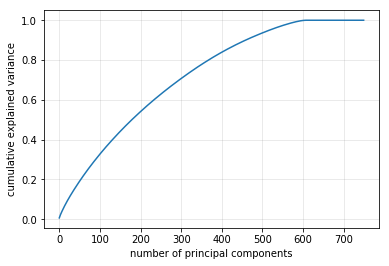

In [136]:
def plot_explained_variance(n_feature, X_train):
    
    pca_full = PCA(n_feature).fit(X_train)
    plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
    plt.xlabel("number of principal components")
    plt.ylabel("cumulative explained variance")
    plt.grid(color='grey',linestyle='-',alpha=0.2)
    plt.show()

plot_explained_variance(5003, cooking_X_train_scaled)

This plot indicates that using 600 principal components are sufficient to explain 100% of the variability in the original data. By reducing the dataset from 5003 to 500 principal components.

Despite of the overall poor performance, the bagged KNN, an ensemble method, achieved the highest test accuracy on the cooking dataset (0.204) by combining multiple KNN classifiers that are fit with the same data and parameters as the single KNN classifier and achieved a lower accuracy (0.188). The training vs testing accuracies of AdaBoost and gradient boosting classifiers indicates that these two boosting methods probably overfit to the dataset, especially considering the fact that the dataset is noisy and high-dimensional.

In [153]:
# sort feature importance according to KNN classifier
n = mushroom_X_train_scaled.shape[1]
knn_mushroom = KNeighborsClassifier(n_neighbors=5)
feature_scores = []
for i in range(n):
    X_i = np.reshape(mushroom_X_df.iloc[:,i:i+1], -1, 1)
    score = np.mean(cross_val_score(knn_mushroom, X_i, mushroom_Y_fit))
    feature_scores.append(score)
m = pd.Series(feature_scores, index=mushroom_X_df.columns)
m.sort_values(ascending=False, inplace=True)
m.head(10)

odor f                        0.783831
stalk-surface-above-ring k    0.774481
stalk-surface-below-ring k    0.766109
gill-size n                   0.756319
spore-print-color h           0.707000
stalk-surface-above-ring s    0.680548
ring-type l                   0.677461
habitat p                     0.625318
spore-print-color w           0.609584
odor s                        0.588892
dtype: float64

Contrary to the cooking dataset, the mushroom dataset yields high performance on all classifiers (a fact also discussed on Kaggle). Sorting feature importance by the cross-validation score on a KNN classifier indicates that several features are very informative in predicting the class (edible or poisonous): 
- odor ('f' and 's')
- stalk surface (above and below ring for 'k' and above rong for 's')
- spore print color ('h' and 'w')
- ring type 'l'
- habitat 'p'

Since all classifiers achieved high accuracies on the mushroom dataset, there's not much room for improvement by using ensemble method. One notiable thing is the relatively poor performance of the AdaBoost classifier on the testing dataset (0.89). This is probably due to the small amount of tree used for boosting: by increasing *n_estimators* from 30 to 100 in the codes below, the ensemble classifer is able to achieve an accuracy of 1.0. 

In [152]:
ab = AdaBoostClassifier(n_estimators=100, random_state=9)
ab.fit(mushroom_X_train_scaled, mushroom_Y_train)
print("Accuracy on test set:", ab.score(mushroom_X_test_scaled, mushroom_Y_test))

Accuracy on test set: 1.0
